# Machine Learning Practical: Coursework 1

**Release date: Monday 10th October 2016**  
**Due date: 16:00 Thursday 27th October 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_1.pdf).

## Part 1: Learning rate schedules

Created Providers


Epoch 5: 1.20s to complete
  error(train)=1.74e-01, acc(train)=9.49e-01, error(valid)=1.72e-01, acc(valid)=9.53e-01, params_penalty=0.00e+00
Epoch 10: 1.42s to complete
  error(train)=1.01e-01, acc(train)=9.72e-01, error(valid)=1.20e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 15: 0.96s to complete
  error(train)=6.74e-02, acc(train)=9.81e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 0.99s to complete
  error(train)=4.74e-02, acc(train)=9.87e-01, error(valid)=9.43e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 25: 0.92s to complete
  error(train)=3.37e-02, acc(train)=9.92e-01, error(valid)=8.59e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 30: 0.92s to complete
  error(train)=2.39e-02, acc(train)=9.95e-01, error(valid)=8.58e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 0.92s to complete
  error(train)=1.78e-02, acc(train)=9.97e-01, error(valid)=9.01e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 4

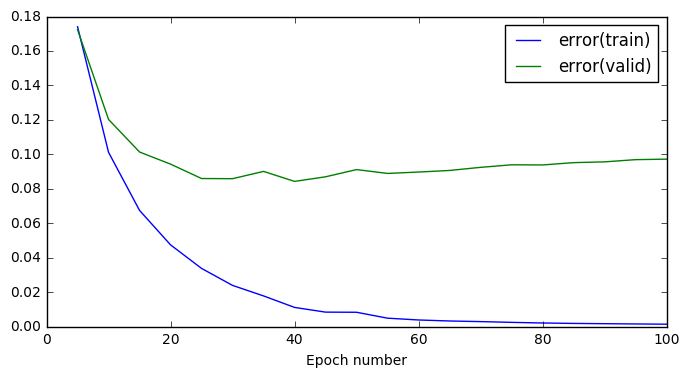

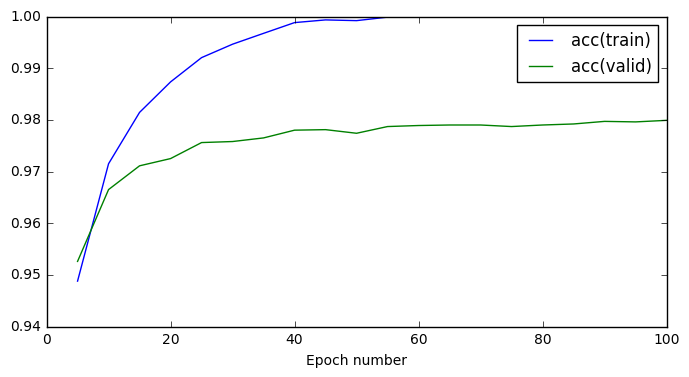

    final error(train) = 1.34e-03
    final error(valid) = 9.72e-02
    final acc(train)   = 1.00e+00
    final acc(valid)   = 9.80e-01
    run time per epoch = 1.10s


[0.2,
 0.0013407044443209842,
 0.097178863672900476,
 1.0,
 0.97989999999999922,
 1.1012503004074097]

In [4]:


'''
My coursework code was not developed in the ipython notebook but in a separate editor. 
While iPython is great for visualisations and debugging I have opted for a developing it outside due to the need for
paralellisation allowing to run multiple trainings silmutaneously.

The code is divided into Tasks and they are all very similar. A training code which contains functions regarding the
network training and also creates worker threads to go handle the trainings. The results are then concatinated and 
stored in a pickle file. This file then can be read a plotter code and also allows to reuse the trained neural network
results.

Some example code is provided below for Task one which trains a single NN.

'''



























# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
import matplotlib.pyplot as plt
from mlp.optimisers import Optimiser
from mlp.schedulers import ConstantLearningRateScheduler,ExpLearningRateScheduler
from mlp.learning_rules import GradientDescentLearningRule
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from multiprocessing.dummy import Pool as ThreadPool
import json


tag_task = 'Task_1'
tag_type = 'Const_rule'

num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
input_dim, output_dim, hidden_dim = 784, 10, 100

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, learning_rate,n=1,r=1):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    
    schedulers = [ConstantLearningRateScheduler(learning_rate)]
    #schedulers = [ExpLearningRateScheduler(n,r)]
    
    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2


def setup_run_with_param(param):
	learning_rate=param
	#n = param[0]
	#r = param[1]
	# Seed a random number generator
	seed = 10102016 
	rng = np.random.RandomState(seed)

	# Set up a logger object to print info about the training run to stdout
	logger = logging.getLogger()
	logger.setLevel(logging.INFO)
	logger.handlers = [logging.StreamHandler()]

	# Create data provider objects for the MNIST data set
	train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
	valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

	print 'Created Providers'


	weights_init = GlorotUniformInit(rng=rng)
	biases_init = ConstantInit(0.)

	model = MultipleLayerModel([
	    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
	    SigmoidLayer(),
	    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
	    SigmoidLayer(),
	    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
	])

	error = CrossEntropySoftmaxError()

	# Use a basic gradient descent learning rule
	learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)	
	#learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

	stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
	    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, learning_rate)

	plt.show()

	print('    final error(train) = {0:.2e}').format(stats[-1, keys['error(train)']])
	print('    final error(valid) = {0:.2e}').format(stats[-1, keys['error(valid)']])
	print('    final acc(train)   = {0:.2e}').format(stats[-1, keys['acc(train)']])
	print('    final acc(valid)   = {0:.2e}').format(stats[-1, keys['acc(valid)']])
	print('    run time per epoch = {0:.2f}s').format(run_time * 1. / num_epochs)

	#return [n,r, stats[-1, keys['error(train)']],stats[-1, keys['error(valid)']],stats[-1, keys['acc(train)']],stats[-1, keys['acc(valid)']],run_time * 1. / num_epochs]
	return [param, stats[-1, keys['error(train)']],stats[-1, keys['error(valid)']],stats[-1, keys['acc(train)']],stats[-1, keys['acc(valid)']],run_time * 1. / num_epochs]


setup_run_with_param(0.2)








Created Providers
1.0
0.367879441171
0.135335283237
0.0497870683679
0.0183156388887


Epoch 5: 0.85s to complete
  error(train)=1.32e-01, acc(train)=9.62e-01, error(valid)=1.36e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


0.00673794699909
0.00247875217667
0.000911881965555
0.000335462627903
0.000123409804087


Epoch 10: 0.93s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


4.53999297625e-05
1.67017007902e-05
6.14421235333e-06
2.26032940698e-06
8.31528719104e-07


Epoch 15: 0.81s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


3.05902320502e-07
1.12535174719e-07
4.13993771879e-08
1.52299797447e-08
5.60279643754e-09


Epoch 20: 0.80s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


2.06115362244e-09
7.58256042791e-10
2.78946809287e-10
1.02618796317e-10
3.77513454428e-11


Epoch 25: 0.84s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


1.3887943865e-11
5.10908902806e-12
1.87952881654e-12
6.91440010694e-13
2.54366564738e-13


Epoch 30: 1.20s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


9.35762296884e-14
3.44247710847e-14
1.26641655491e-14
4.6588861451e-15
1.71390843154e-15


Epoch 35: 1.01s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


6.30511676015e-16
2.31952283024e-16
8.53304762574e-17
3.13913279205e-17
1.1548224173e-17


Epoch 40: 0.92s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


4.24835425529e-18
1.56288218933e-18
5.74952226429e-19
2.11513103759e-19
7.78113224113e-20


Epoch 45: 1.18s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


2.86251858055e-20
1.05306173576e-20
3.87399762869e-21
1.42516408274e-21
5.24288566336e-22


Epoch 50: 0.90s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


1.92874984796e-22
7.09547416228e-23
2.61027906967e-23
9.60268005451e-24
3.5326285722e-24


Epoch 55: 1.08s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


1.29958142501e-24
4.78089288389e-25
1.75879220242e-25
6.47023492565e-26
2.38026640869e-26


Epoch 60: 1.49s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


8.7565107627e-27
3.22134028599e-27
1.18506486423e-27
4.35961000006e-28
1.60381089055e-28


Epoch 65: 0.81s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


5.9000905416e-29
2.1705220113e-29
7.98490424569e-30
2.93748211171e-30
1.08063927771e-30


Epoch 70: 0.81s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


3.97544973591e-31
1.46248622725e-31
5.38018616002e-32
1.97925987795e-32
7.28129017832e-33


Epoch 75: 0.83s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


2.67863696181e-33
9.85415468611e-34
3.62514091914e-34
1.3336148155e-34
4.90609473065e-35


Epoch 80: 0.80s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


1.80485138785e-35
6.63967719958e-36
2.44260073774e-36
8.98582594405e-37
3.30570062676e-37


Epoch 85: 0.91s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


1.21609929925e-37
4.47377930618e-38
1.64581143108e-38
6.0546018954e-39
2.2273635618e-39


Epoch 90: 0.76s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


8.19401262399e-40
3.01440878507e-40
1.10893901931e-40
4.07955866718e-41
1.50078576271e-41


Epoch 95: 0.77s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


5.52108227703e-42
2.03109266273e-42
7.47197233734e-43
2.74878500791e-43
1.01122149261e-43


Epoch 100: 1.41s to complete
  error(train)=1.31e-01, acc(train)=9.62e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=0.00e+00


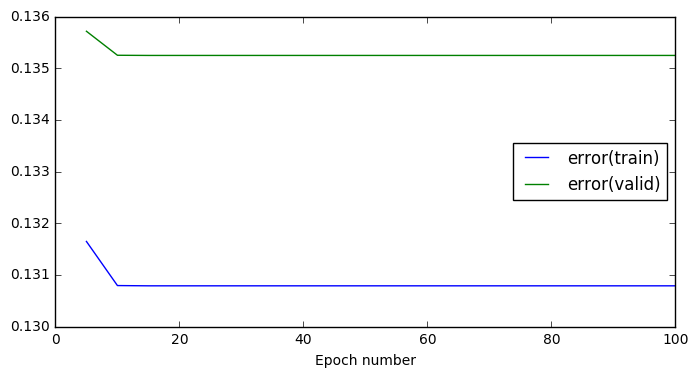

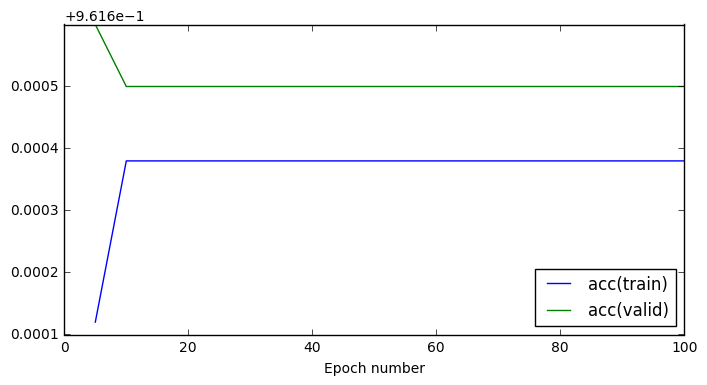

	   param 1 1
    final error(train) = 1.31e-01
    final error(valid) = 1.35e-01
    final acc(train)   = 9.62e-01
    final acc(valid)   = 9.62e-01
    run time per epoch = 1.04s


[1,
 1,
 0.13078728448877386,
 0.1352463939914795,
 0.96198000000001005,
 0.96209999999999918,
 1.0432673501968384]

In [5]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
import matplotlib.pyplot as plt
from mlp.optimisers import Optimiser
from mlp.schedulers import ConstantLearningRateScheduler,ExpLearningRateScheduler
from mlp.learning_rules import GradientDescentLearningRule
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from multiprocessing.dummy import Pool as ThreadPool
import json


tag_task = 'Task_1'
tag_type = 'Exp_rule'

num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
input_dim, output_dim, hidden_dim = 784, 10, 100

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, learning_rate,n=1,r=1):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    
    #schedulers = [ConstantLearningRateScheduler(learning_rate)]
    schedulers = [ExpLearningRateScheduler(n,r)]
    
    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2


def setup_run_with_param(param):
	#learning_rate = param
	learning_rate=0.2
	n = param[0]
	r = param[1]
	# Seed a random number generator
	seed = 10102016 
	rng = np.random.RandomState(seed)

	# Set up a logger object to print info about the training run to stdout
	logger = logging.getLogger()
	logger.setLevel(logging.INFO)
	logger.handlers = [logging.StreamHandler()]

	# Create data provider objects for the MNIST data set
	train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
	valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

	print 'Created Providers'

	weights_init = GlorotUniformInit(rng=rng)
	biases_init = ConstantInit(0.)

	model = MultipleLayerModel([
	    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
	    SigmoidLayer(),
	    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
	    SigmoidLayer(),
	    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
	])

	error = CrossEntropySoftmaxError()

	# Use a basic gradient descent learning rule
	learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

	stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
	    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, learning_rate,n,r)

	plt.show()


	print('	   param '+ str(n)+' '+str(r) )
	print('    final error(train) = {0:.2e}').format(stats[-1, keys['error(train)']])
	print('    final error(valid) = {0:.2e}').format(stats[-1, keys['error(valid)']])
	print('    final acc(train)   = {0:.2e}').format(stats[-1, keys['acc(train)']])
	print('    final acc(valid)   = {0:.2e}').format(stats[-1, keys['acc(valid)']])
	print('    run time per epoch = {0:.2f}s').format(run_time * 1. / num_epochs)

	return [n,r, stats[-1, keys['error(train)']],stats[-1, keys['error(valid)']],stats[-1, keys['acc(train)']],stats[-1, keys['acc(valid)']],run_time * 1. / num_epochs]

'''
pool = ThreadPool(16) 
my_array = [[1,1],[1,5],[1,10],[1,20],[1,0.5],[1,0.1],[0.5,1],[0.5,5],[0.5,10],[0.5,20],[0.5,0.5],[0.5,0.1],[2,1],[2,5],[2,10],[2,20],[2,0.5],[2,0.1]]

results = pool.map(setup_run_with_param, my_array)
print results
with open('figures/'+tag_task+'/'+tag_type+'.txt', "w+") as f:
	json.dump(results,f)	
'''
setup_run_with_param([1,1])


## Part 2: Momentum learning rule

## Part 3: Adaptive learning rules